# Drive connect

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
base = '/content/drive/My Drive/GaTech/sem1/epi'
import os
os.chdir(base)
# drive.flush_and_unmount()

In [3]:
os.chdir(os.path.join(base, 'own_imp'))

# Imports

In [4]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
import joblib
import pandas as pd
from pandas.core.api import isnull
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
import plotly.express as px

# Data pre-processing

In [ ]:
dataDir = 'data'

## Data loading

In [ ]:
import pandas as pd

years = [2017, 2018, 2019, 2020, 2021]
for idx, year in enumerate(years):
    dataPath = os.path.join(dataDir, f"{year}_country_weekly_{year}_US_weekly_symptoms_dataset.csv")
    if not idx:
        country_df = pd.read_csv(dataPath)
    else:
        country_df = pd.concat([country_df, pd.read_csv(dataPath)])

## Check which regions have poor data quality

In [ ]:
all_regions = set(country_df['sub_region_1'].values[~pd.isnull(country_df['sub_region_1'])])
clean_ul = 0
mod_ul = clean_ul
clean_regions = []
mod_regions = []
bad_regions = []
for region in all_regions:
    region_data = country_df[country_df['sub_region_1']==region].values[:,8:]
    num_missing = pd.isnull(region_data).any(axis=1).sum()
    total = region_data.shape[0]*region_data.shape[1]
    # print(f"Region: {region} | Number of missing values: {num_missing} | % of missing values: {num_missing*100/total}")
    if num_missing <= clean_ul:
        clean_regions.append(region)
    elif (num_missing <= mod_ul):
        mod_regions.append(region)
    else:
        bad_regions.append(region)

print(f"Clean Regions: Size = {len(clean_regions)}")
print(clean_regions)

print(f"Moderate clean Regions: Size = {len(mod_regions)}")
print(mod_regions)

print(f"Bad Regions: Size = {len(bad_regions)}")
print(bad_regions)

Clean Regions: Size = 15
['Colorado', 'Georgia', 'North Carolina', 'Illinois', 'Ohio', 'Washington', 'New York', 'Massachusetts', 'Florida', 'New Jersey', 'Arizona', 'Michigan', 'Texas', 'California', 'Pennsylvania']
Moderate clean Regions: Size = 0
[]
Bad Regions: Size = 36
['South Dakota', 'South Carolina', 'Delaware', 'Kentucky', 'Arkansas', 'Louisiana', 'Virginia', 'Connecticut', 'Missouri', 'Hawaii', 'Utah', 'District of Columbia', 'Alaska', 'North Dakota', 'Idaho', 'Mississippi', 'Montana', 'New Mexico', 'Minnesota', 'Wisconsin', 'Maine', 'Alabama', 'Nebraska', 'Nevada', 'Vermont', 'Oklahoma', 'Tennessee', 'West Virginia', 'Indiana', 'Wyoming', 'Maryland', 'Oregon', 'Iowa', 'Rhode Island', 'Kansas', 'New Hampshire']


## Helper function

In [ ]:
def trainImputer(imp, country_df, clean_regions, num_mask_percent = 30, imp_save_dir = "imp_models", imp_filename = f"clean_regions.save"):
    imp_save_dir = "imp_models"
    if not os.path.exists(imp_save_dir):
        os.makedirs(imp_save_dir)
    region2orig_val = {}
    region2mask_row_idx = {}
    region2mask_col_idx = {}
    region2data_df = {}
    for clean_region in clean_regions:
        clean_region_df = country_df[country_df['sub_region_1']==clean_region].iloc[:,8:]
        clean_region_df.dropna(inplace=True)
        clean_region_data = clean_region_df.values

        clean_region_data_original = clean_region_data.copy()
        nRows, nCols = clean_region_data.shape
        random_nan_row_idxs = np.random.choice(range(nRows), size=int(num_mask_percent*nRows/100), replace=False)
        random_nan_col_idxs = np.random.choice(range(nCols), size=int(num_mask_percent*nCols/100), replace=False)
        original_values = []
        for i in random_nan_row_idxs:
            for j in random_nan_col_idxs:
                orig_value = clean_region_data[i,j]
                original_values.append(orig_value)
                clean_region_data[i,j] = np.nan
        
        print(f"Region: {clean_region} | Number of masked elements: {len(original_values)}")
        
        region2data_df[clean_region] = clean_region_data
        region2mask_row_idx[clean_region] = random_nan_row_idxs
        region2mask_col_idx[clean_region] = random_nan_col_idxs
        region2orig_val[clean_region] = original_values

        imp.fit(clean_region_data)

    imp_path = os.path.join(imp_save_dir, imp_filename)
    joblib.dump(imp, imp_path)
    return imp, region2data_df, region2orig_val, region2mask_row_idx, region2mask_col_idx

In [ ]:
def testHQRegions(imp, region2data_df, clean_regions, region2orig_val, region2mask_row_idx, region2mask_col_idx, num_mask_percent=30):
    clean_overall_original = []
    clean_overall_imputed = []
    print(f"Results in testing on regions with high data quality: ")
    for clean_region in clean_regions:
        clean_region_data = region2data_df[clean_region]
        original_values = np.array(region2orig_val[clean_region])
        random_nan_row_idxs = region2mask_row_idx[clean_region]
        random_nan_col_idxs = region2mask_col_idx[clean_region]
        imputed_values = []
        region_imputed = imp.transform(clean_region_data)
        for i in random_nan_row_idxs:
            for j in random_nan_col_idxs:
                imputed_values.append(region_imputed[i,j])
        imputed_values = np.array(imputed_values)
        clean_region_rmse =  np.sqrt(np.mean((imputed_values-original_values)**2))
        print(f"Region: {clean_region} | RMSE: {clean_region_rmse}")
        clean_overall_original.extend(original_values)
        clean_overall_imputed.extend(imputed_values)

    clean_overall_imputed = np.array(clean_overall_imputed)
    clean_overall_original = np.array(clean_overall_original)
    clean_overall_rmse = np.sqrt(np.mean((clean_overall_imputed-clean_overall_original)**2))
    print(f"Overall RMSE for regions with high data quality: {clean_overall_rmse}")

In [ ]:
def testLQRegions(imp, country_df, bad_regions, num_mask_percent=30):
    bad_overall_original = []
    bad_overall_imputed = []
    print(f"Results in testing on regions with bad data quality: ")
    for bad_region in bad_regions:
        bad_region_df = country_df[country_df['sub_region_1']==bad_region].iloc[:,8:]
        bad_region_data = bad_region_df.values
        bad_region_data_original = bad_region_data.copy()
        
        nRows, nCols = bad_region_data.shape
        random_total_nan_row_idxs = np.random.choice(range(nRows), size=int(num_mask_percent*nRows/100), replace=False)
        random_total_nan_col_idxs = np.random.choice(range(nCols), size=int(num_mask_percent*nCols/100), replace=False)
        
        random_nan_idxs = []
        original_values = []
        for i in random_total_nan_row_idxs:
            for j in random_total_nan_col_idxs:
                if not pd.isnull(bad_region_data[i,j]):
                    orig_value = bad_region_data[i,j]
                    original_values.append(orig_value)
                    bad_region_data[i,j] = np.nan
                    random_nan_idxs.append((i,j))

        imputed_values = []
        region_imputed = imp.transform(bad_region_data)
        for (i,j) in random_nan_idxs:
            imputed_values.append(region_imputed[i,j])
        imputed_values = np.array(imputed_values)
        bad_region_rmse =  np.sqrt(np.mean((imputed_values-original_values)**2))
        print(f"Region: {bad_region} | RMSE: {bad_region_rmse}")
        bad_overall_original.extend(original_values)
        bad_overall_imputed.extend(imputed_values)

    bad_overall_imputed = np.array(bad_overall_imputed)
    bad_overall_original = np.array(bad_overall_original)
    bad_overall_rmse = np.sqrt(np.mean((bad_overall_imputed-bad_overall_original)**2))
    print(f"Overall RMSE for regions with bad data quality: {bad_overall_rmse}")

## MICE imputation

In [ ]:
imp_save_dir = "imp_models"
imp_filename = "clean_regions_iter.save"
iter_imp = IterativeImputer(max_iter=10, random_state=0)

In [ ]:
iter_imp, region2data_df, region2orig_val, region2mask_row_idx, region2mask_col_idx = trainImputer(iter_imp, country_df, clean_regions, num_mask_percent = 30, imp_save_dir = "imp_models", imp_filename = f"clean_regions.save")

In [ ]:
imp_save_dir = "imp_models"
imp_filename = "clean_regions_iter.save"
imp_path = os.path.join(imp_save_dir, imp_filename)
iter_imp = joblib.load(imp_path) 

In [ ]:
testHQRegions(iter_imp, region2data_df, clean_regions, region2orig_val, region2mask_row_idx, region2mask_col_idx, num_mask_percent=30)

In [ ]:
testLQRegions(iter_imp, country_df, bad_regions, num_mask_percent=30)

## KNN based imputation

In [ ]:
imp_save_dir = "imp_models"
imp_filename = "clean_regions_knn.save"
knn_imp = KNNImputer(n_neighbors=25, weights="distance")

In [ ]:
knn_imp, region2data_df, region2orig_val, region2mask_row_idx, region2mask_col_idx = trainImputer(knn_imp, country_df, clean_regions, num_mask_percent = 30, imp_save_dir = imp_save_dir, imp_filename = imp_filename)

Region: Arizona | Number of masked elements: 8568
Region: Washington | Number of masked elements: 8568
Region: New Jersey | Number of masked elements: 8568
Region: Michigan | Number of masked elements: 8568
Region: Pennsylvania | Number of masked elements: 8568
Region: Colorado | Number of masked elements: 8568
Region: Massachusetts | Number of masked elements: 8568
Region: Georgia | Number of masked elements: 8568
Region: New York | Number of masked elements: 8568
Region: North Carolina | Number of masked elements: 8568
Region: Florida | Number of masked elements: 8568
Region: California | Number of masked elements: 8568
Region: Ohio | Number of masked elements: 8568
Region: Texas | Number of masked elements: 8568
Region: Illinois | Number of masked elements: 8568


In [ ]:
imp_save_dir = "imp_models"
imp_filename = "clean_regions_knn.save"
imp_path = os.path.join(imp_save_dir, imp_filename)
knn_imp = joblib.load(imp_path) 

In [ ]:
testHQRegions(knn_imp, region2data_df, clean_regions, region2orig_val, region2mask_row_idx, region2mask_col_idx, num_mask_percent=30)

Results in testing on regions with high data quality: 
Region: Arizona | RMSE: 0.324938871103864
Region: Washington | RMSE: 0.6140593832489649
Region: New Jersey | RMSE: 0.24405488793241217
Region: Michigan | RMSE: 0.23501924487823944
Region: Pennsylvania | RMSE: 0.2622649954543236
Region: Colorado | RMSE: 0.2062953038456528
Region: Massachusetts | RMSE: 0.14157830813276215
Region: Georgia | RMSE: 0.6800952257443424
Region: New York | RMSE: 0.17993749333011408
Region: North Carolina | RMSE: 0.30114638879280453
Region: Florida | RMSE: 0.7027477656657736
Region: California | RMSE: 0.5812972875522829
Region: Ohio | RMSE: 0.16758153996559896
Region: Texas | RMSE: 0.672036532954961
Region: Illinois | RMSE: 0.18076459586085816
Overall RMSE for regions with high data quality: 0.4209976852251058


In [ ]:
testLQRegions(knn_imp, country_df, bad_regions, num_mask_percent=30)

Results in testing on regions with bad data quality: 
Region: Wisconsin | RMSE: 0.6112732600633951
Region: New Mexico | RMSE: 0.3922702633020003
Region: Oklahoma | RMSE: 0.43954071465623
Region: Hawaii | RMSE: 0.9932519027576371
Region: West Virginia | RMSE: 0.7342002831241798
Region: Indiana | RMSE: 0.297312531271007
Region: Alabama | RMSE: 0.3779768205566872
Region: Arkansas | RMSE: 0.5376236027542324
Region: District of Columbia | RMSE: 0.25325729476094716
Region: Connecticut | RMSE: 0.5808475570215801
Region: Minnesota | RMSE: 0.48847049000225196
Region: Nevada | RMSE: 0.32181538902559775
Region: Delaware | RMSE: 0.18845035548932798
Region: Kansas | RMSE: 0.38251489625040985
Region: Kentucky | RMSE: 0.2684481898825553
Region: New Hampshire | RMSE: 0.4924942978228878
Region: South Carolina | RMSE: 0.8463316929649249
Region: Virginia | RMSE: 0.3309089706573366
Region: Iowa | RMSE: 0.28897283284609
Region: Maryland | RMSE: 0.19528792702026143
Region: Rhode Island | RMSE: 0.49121011719

## Interpolation based imputation [Pandas]

In [ ]:
def pandasInterp(country_df, clean_regions, method="linear", num_mask_percent=30):
    clean_overall_imputed = []
    clean_overall_original = []
    region2orig = {}
    
    for idx, clean_region in enumerate(clean_regions):  
        clean_region_df = country_df[country_df['sub_region_1']==clean_region].iloc[:,8:]
        clean_region_df.dropna(inplace=True)

        if idx == 0:
            overall_clear_region_df = clean_region_df
        else:
            overall_clear_region_df = pd.concat([overall_clear_region_df, clean_region_df])
    

    nRows, nCols = overall_clear_region_df.shape
    random_nan_row_idxs = np.random.choice(range(nRows), size=int(num_mask_percent*nRows/100), replace=False)
    random_nan_col_idxs = np.random.choice(range(nCols), size=int(num_mask_percent*nCols/100), replace=False)
    original_values = []
    for i in random_nan_row_idxs:
        for j in random_nan_col_idxs:
            orig_value = overall_clear_region_df.iloc[i,j]
            original_values.append(orig_value)
            overall_clear_region_df.iloc[i,j] = np.nan
    original_values = np.array(original_values)
    
    overall_clear_region_df.interpolate(method=method, inplace=True)

    imputed_values = []
    for i in random_nan_row_idxs:
        for j in random_nan_col_idxs:
            imputed_values.append(overall_clear_region_df.iloc[i,j])
    imputed_values = np.array(imputed_values)
    clean_overall_rmse =  np.sqrt(np.mean((original_values-imputed_values)**2))
    print(f"Overall RMSE for the regions: {clean_overall_rmse}")
    

In [ ]:
print("Clean Regions:")
pandasInterp(country_df, clean_regions, method="linear", num_mask_percent=30)

Clean Regions:
Overall RMSE for the regions: 0.14211753906807403


In [ ]:
print("Bad Regions:")
pandasInterp(country_df, bad_regions, method="linear", num_mask_percent=30)

Bad Regions:
Overall RMSE for the regions: 0.41548013120485977


 # Anomaly detection

## On CDC covid cases

In [94]:
dataDir = 'data'
filename = "COVID-19_Hospital_Data_from_the_National_Hospital_Care_Survey.csv"
dataPath = os.path.join(dataDir, filename)
country_df = pd.read_csv(dataPath)
country_df = country_df[country_df['Figure'] == '0']
country_df['Value'] = country_df['Value'].apply(lambda x:int(float("".join(str(x).split(',')))))
country_df['End_Time'] = pd.to_datetime(country_df['End_Time'])
covid_cases = country_df['Value'].values
trunc_country_df = country_df[['End_Time', 'Value']]
trunc_country_df = trunc_country_df.set_index('End_Time').resample('W').mean().reset_index()
trunc_country_df.shape

(115, 2)

In [95]:
trunc_country_df = trunc_country_df.reset_index()[['End_Time', 'Value']].rename({'End_Time':'ds', 'Value':'y'}, axis='columns')

In [96]:
trunc_country_df.head()

,ds,y
0,2020-03-29,19760.0
1,2020-04-05,17159.5
2,2020-04-12,15153.0
3,2020-04-19,14234.0
4,2020-04-26,14314.5


In [114]:
train = trunc_country_df[(trunc_country_df['ds'] >= '2020-03-24') & (trunc_country_df['ds'] <= '2021-11-7')]
test = trunc_country_df[(trunc_country_df['ds'] > '2021-11-7')]
print(train.shape, test.shape)

(85, 2) (30, 2)


In [148]:
m = Prophet(growth='linear', changepoint_range=0.95)

In [149]:
m.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_7h3nb31/rfa4xoot.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_7h3nb31/6wrh91rc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8028', 'data', 'file=/tmp/tmp_7h3nb31/rfa4xoot.json', 'init=/tmp/tmp_7h3nb31/6wrh91rc.json', 'output', 'file=/tmp/tmp_7h3nb31/prophet_modelm0f310av/prophet_model-20221123032353.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:23:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:23:53 - cmdstanpy - INFO - Chain 

In [150]:
periods = test.shape[0]
future = m.make_future_dataframe(periods=periods, freq='W')

In [151]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
110,2022-05-08,29719.771509,27945.961007,31350.671255
111,2022-05-15,29826.668672,28049.640365,31550.406125
112,2022-05-22,29933.565836,28154.321247,31655.037550
113,2022-05-29,30040.462999,28341.083450,31779.227992
114,2022-06-05,30147.360163,28441.879431,31874.506914


In [146]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-29,16573.460190,14762.085085,18274.637133,16573.460190,16573.460190,0.0,0.0,0.0,0.0,0.0,0.0,16573.460190
1,2020-04-05,16747.196290,14974.454336,18384.388039,16747.196290,16747.196290,0.0,0.0,0.0,0.0,0.0,0.0,16747.196290
2,2020-04-12,16920.932391,15122.299335,18634.348428,16920.932391,16920.932391,0.0,0.0,0.0,0.0,0.0,0.0,16920.932391
3,2020-04-19,17094.668491,15404.807293,18985.090116,17094.668491,17094.668491,0.0,0.0,0.0,0.0,0.0,0.0,17094.668491
4,2020-04-26,17268.404592,15602.948392,19016.391096,17268.404592,17268.404592,0.0,0.0,0.0,0.0,0.0,0.0,17268.404592


In [147]:
trunc_country_df.head()

,ds,y
0,2020-03-29,19760.0
1,2020-04-05,17159.5
2,2020-04-12,15153.0
3,2020-04-19,14234.0
4,2020-04-26,14314.5


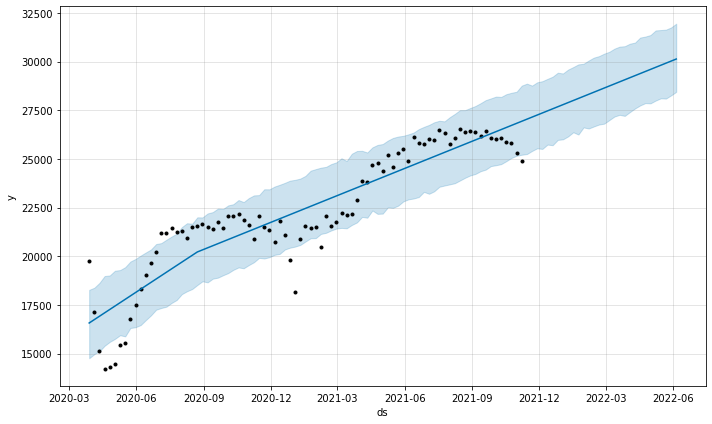

In [144]:
result = pd.concat([trunc_country_df.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
fig1 = m.plot(forecast)

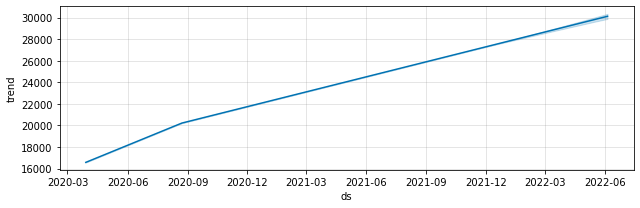

In [129]:
comp = m.plot_components(forecast)

In [39]:
result['error'] = result['y'] - result['yhat']
result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']
result['anomaly'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) > 3*x['uncertainty']) else 'No', axis = 1)

In [40]:
fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title='Covid cases')
#slider
# fig.update_xaxes(
#     rangeslider_visible = True,
#     rangeselector = dict(
#         buttons = list([
#               dict(count=1, label='1y', step="year", stepmode="backward"),
#               dict(count=2, label='3y', step="year", stepmode="backward"),
#               dict(count=2, label='5y', step="year", stepmode="backward"),
#               dict(step="all")
#         ])
#     )
# )
fig.show()

## On top symptoms

In [41]:
granger_symptoms = ['symptom:Eye pain', 'symptom:Night sweats', 'symptom:Headache',
        'symptom:Throat irritation', 'symptom:Low-grade fever',
        'symptom:Chills', 'symptom:Nasal congestion', 'symptom:Shivering',
        'symptom:Myalgia', 'symptom:Cardiac arrest', 'symptom:Sinusitis',
        'symptom:Post-nasal drip', 'symptom:Sore throat',
        'symptom:Heart murmur', 'symptom:Migraine', 'symptom:Hypoxemia',
        'symptom:Phlegm', 'symptom:Atheroma', 'symptom:Arthralgia',
        'symptom:Dysgeusia']

In [42]:
import pandas as pd

dataDir = 'data'
years = [2017, 2018, 2019, 2020, 2021]
for idx, year in enumerate(years):
    dataPath = os.path.join(dataDir, f"{year}_country_weekly_{year}_US_weekly_symptoms_dataset.csv")
    if not idx:
        country_region_df = pd.read_csv(dataPath)
    else:
        country_region_df = pd.concat([country_region_df, pd.read_csv(dataPath)])

In [43]:
trunc_country_region_df = country_region_df[['sub_region_1', 'date', 'symptom:Eye pain', 'symptom:Night sweats', 'symptom:Headache',
        'symptom:Throat irritation', 'symptom:Low-grade fever',
        'symptom:Chills', 'symptom:Nasal congestion']]
trunc_country_df = trunc_country_region_df[trunc_country_region_df['sub_region_1'].isna()].drop(['sub_region_1'], axis=1)
trunc_country_df['date'] = pd.to_datetime(trunc_country_df['date'])

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpklmwio/_sb3nich.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpklmwio/w7_qyscd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15046', 'data', 'file=/tmp/tmpxpklmwio/_sb3nich.json', 'init=/tmp/tmpxpklmwio/w7_qyscd.json', 'output', 'file=/tmp/tmpxpklmwio/prophet_modelrnu97d5a/prophet_model-20221123203612.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:36:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:36:12 - cmdstanpy - INFO - Chain

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpklmwio/9wt85qy0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpklmwio/0ldrt3zw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8950', 'data', 'file=/tmp/tmpxpklmwio/9wt85qy0.json', 'init=/tmp/tmpxpklmwio/0ldrt3zw.json', 'output', 'file=/tmp/tmpxpklmwio/prophet_model67s4iuit/prophet_model-20221123203613.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:36:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


########


20:36:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpklmwio/qjopnjzy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpklmwio/ew9y6kbj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88698', 'data', 'file=/tmp/tmpxpklmwio/qjopnjzy.json', 'init=/tmp/tmpxpklmwio/ew9y6kbj.json', 'output', 'file=/tmp/tmpxpklmwio/prophet_modelise2o8o3/prophet_model-20221123203614.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:36:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


########


20:36:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpklmwio/kbizgoug.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpklmwio/un49snif.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27043', 'data', 'file=/tmp/tmpxpklmwio/kbizgoug.json', 'init=/tmp/tmpxpklmwio/un49snif.json', 'output', 'file=/tmp/tmpxpklmwio/prophet_modeli2wg_zvu/prophet_model-20221123203615.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:36:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


########


20:36:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpklmwio/aow90wsq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxpklmwio/fxg9gz8o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=280', 'data', 'file=/tmp/tmpxpklmwio/aow90wsq.json', 'init=/tmp/tmpxpklmwio/fxg9gz8o.json', 'output', 'file=/tmp/tmpxpklmwio/prophet_modelsz2edq80/prophet_model-20221123203616.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:36:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


########


20:36:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


########


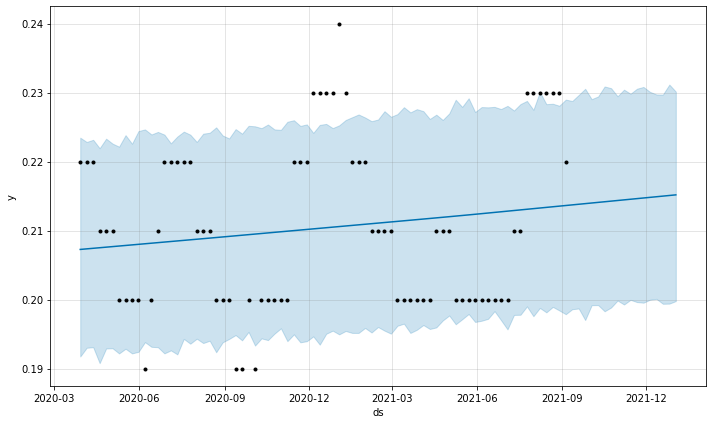

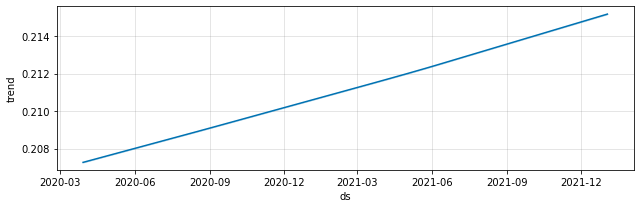

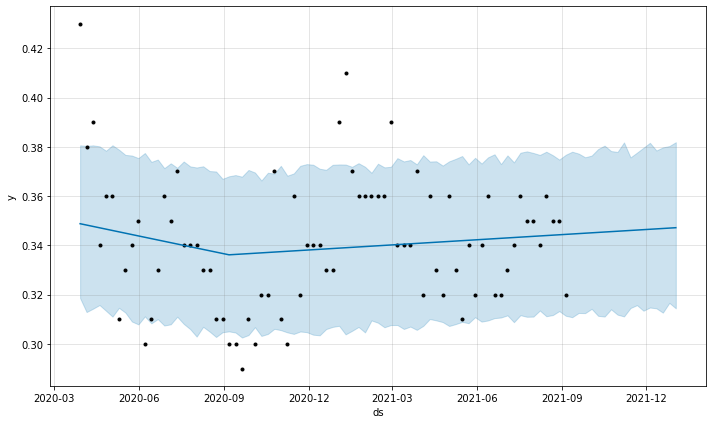

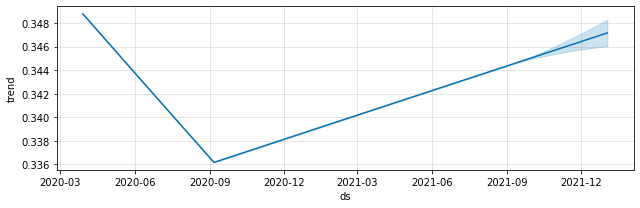

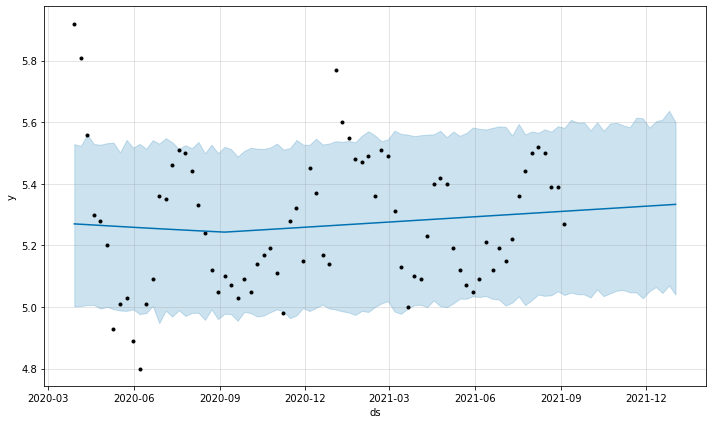

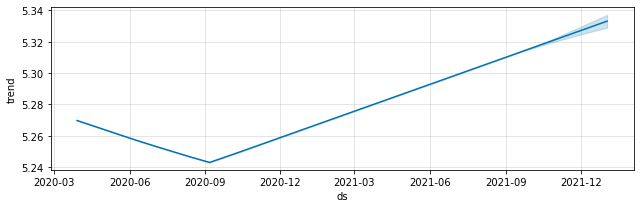

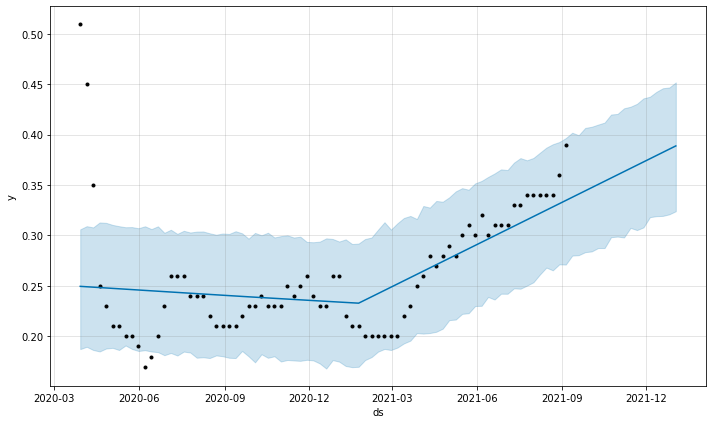

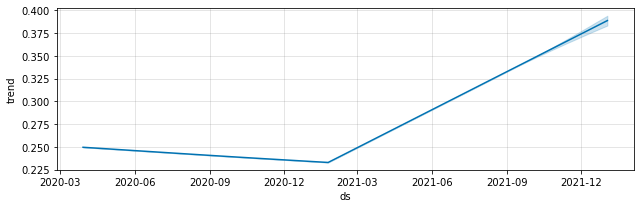

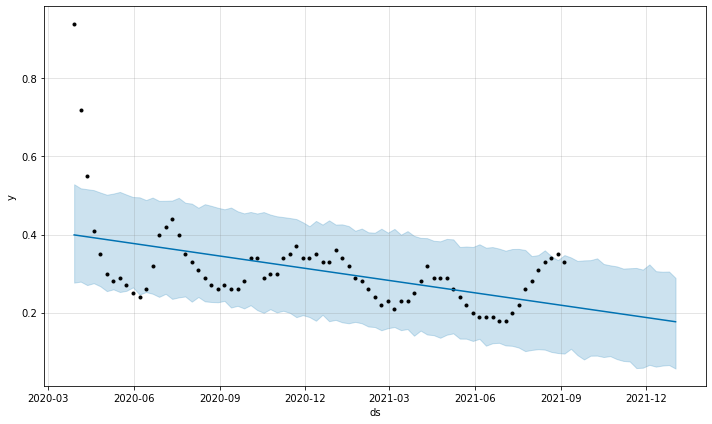

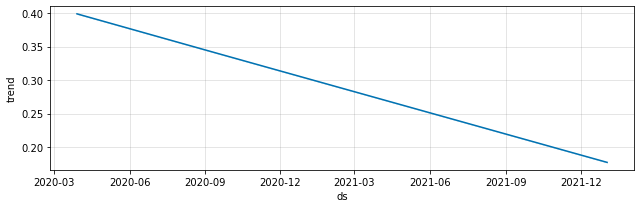

In [45]:
symptom = 'symptom:Throat irritation'
for symptom in granger_symptoms[:5]:
    covid_cases = trunc_country_df[symptom].values
    symp_trunc_country_df = trunc_country_df[['date', symptom]]
    symp_trunc_country_df = symp_trunc_country_df.set_index('date').resample('W').mean().reset_index()
    symp_trunc_country_df = symp_trunc_country_df.reset_index()[['date', symptom]].rename({'date':'ds', symptom:'y'}, axis='columns')
    train = symp_trunc_country_df[(symp_trunc_country_df['ds'] >= '2020-03-24') & (symp_trunc_country_df['ds'] <= '2021-9-7')]
    test = symp_trunc_country_df[(symp_trunc_country_df['ds'] > '2021-9-7')]
    m = Prophet(growth='linear', changepoint_range=0.95)
    m.fit(train)
    periods = test.shape[0]
    future = m.make_future_dataframe(periods=periods, freq='W')
    forecast = m.predict(future)
    forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()
    result = pd.concat([symp_trunc_country_df.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
    fig1 = m.plot(forecast)
    comp = m.plot_components(forecast)
    result['error'] = result['y'] - result['yhat']
    result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']
    result['anomaly'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis = 1)
    fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title=symptom)
    fig.show()
    print("########")